# Histopathologic Cancer Detection using Deep Learning

### 0. Importamos las librerias necesarias para el analisis de las imágenes y la realización de las predicciones

In [ ]:
import numpy as np 
import pandas as pd
from glob import glob 
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import shutil
import keras.backend as K

## 1. Preprocesamiento de los datos

### 1.1 Armamos el dataframe con el conjunto de datos de entrenamiento

In [ ]:
train_dir = '../iis-project/train'
df = pd.DataFrame({'path': glob(os.path.join(train_dir,'*.tif'))})
labels = pd.read_csv("../iis-project/train_labels.csv")
df['label'] = labels['label']
df.head(10)



### 1.2 Se selecciona una muestra de cada etiqueta

           
    Se crean 2 dataframes, uno para cada etiqueta, cada uno de ellos con 10000 elementos ya que tomar en cuenta todo el conjunto no resulta práctico por las limitaciones de recursos fisicos como memoria RAM y/o disco. A partir de estos dataframes se crea uno nuevo que contenga el conjunto de datos reducido.

In [ ]:
sample_label0 = df[df.label == 0].sample(1000, random_state=50)
sample_label1 = df[df.label == 1].sample(1000, random_state=50)


reduced_df = pd.DataFrame(pd.concat([sample_label0, sample_label1]))
reduced_df

In [ ]:
directory_1 = "../iis-project/red_train"
directory_2 = "../iis-project/red_validation"

shutil.rmtree(directory_1)
shutil.rmtree(directory_2)

if not os.path.exists(directory_1):
    os.makedirs(directory_1)
if not os.path.exists(directory_2):
    os.makedirs(directory_2)

for folder in [directory_1, directory_2]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

In [ ]:
from sklearn.model_selection import train_test_split

#Stratifying data into train and validation with label 0
X_train0, X_val0, y_train0, y_val0 = train_test_split(
        sample_label0['path'],sample_label0['label'], test_size=0.3, random_state=42)

#Stratifying data into train and validation with label 1
X_train1, X_val1, y_train1, y_val1 = train_test_split(
        sample_label1['path'],sample_label1['label'], test_size=0.3, random_state=42)


lt0 = X_train0.tolist()
lt1 = X_train1.tolist()
lv0 = X_val0.tolist()
lv1 = X_val1.tolist()
for files in lt0:
    shutil.copy(files, os.path.join(directory_1,'0'))
for files in lt1:
    shutil.copy(files, os.path.join(directory_1,'1'))
for files in lv0:
    shutil.copy(files, os.path.join(directory_2,'0'))
for files in lv1:
    shutil.copy(files, os.path.join(directory_2,'1'))



## 2. Comparación de modelos

## 2.1 Transfer Learning

### 2.1.1 Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

### 2.1.2 Entrenamos el modelo

In [32]:
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
import math

img_width, img_height = 96, 96
BATCH_SIZE = 32

model_1 = Sequential()
model_1.add(Conv2D(32, 3, 3, input_shape = (img_width, img_height, 3), activation = 'relu'))
model_1.add(MaxPooling2D(2, 2))
model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='sgd',
              loss='binary_crossentropy', metrics=['accuracy'])


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory_1,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        directory_2,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

history = model_1.fit_generator(
                train_generator,
                steps_per_epoch=math.ceil((len(lt0) + len(lt1)) / BATCH_SIZE),
                epochs=10,
                validation_data=validation_generator,
                validation_steps=((len(lv0) + len(lv1)) / BATCH_SIZE))


/home/am013la/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 3..., activation="relu")`
  del sys.path[0]


Found 1400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
44/44 [==============================] - 20s 456ms/step - loss: 0.7131 - acc: 0.5043 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 2/10
44/44 [==============================] - 18s 412ms/step - loss: 0.6956 - acc: 0.5017 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 3/10
44/44 [==============================] - 19s 423ms/step - loss: 0.6949 - acc: 0.4903 - val_loss: 0.6933 - val_acc: 0.4983
Epoch 4/10
44/44 [==============================] - 18s 411ms/step - loss: 0.6942 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5033
Epoch 5/10
44/44 [==============================] - 19s 434ms/step - loss: 0.6943 - acc: 0.5066 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/10
44/44 [==============================] - 21s 470ms/step - loss: 0.6939 - acc: 0.4927 - val_loss: 0.6931 - val_acc: 0.5233
Epoch 7/10
44/44 [==============================] - 20s 444ms/step - loss: 0.6939 - acc: 0.5005 - val_loss: 0.6932 - va

In [33]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 70688)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 70688)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               9048192   
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 9,049,217
Trainable params: 9,049,217
Non-trainable params: 0
_________________________________________________________________


### 2.1.3 Generamos las graficas con las medidas de desempeño

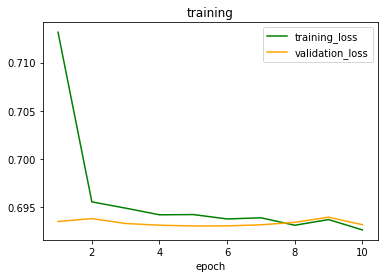

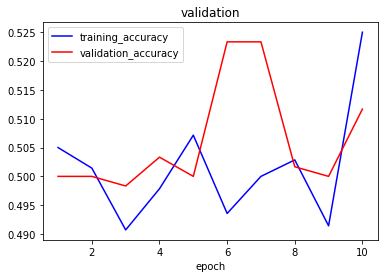

In [34]:
# Training plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='green', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='orange', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.show()
plt.close()

plt.plot(epochs, history.history['acc'], color='green', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='orange',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.show()
plt.close()

### 2.1.4 Creamos el archivo csv con las predicciones

### 2.1.5 Obtenemos el area bajo la curva ROC